<a href="https://colab.research.google.com/github/YousefFayez20/QR-Enhancement-And-Detection/blob/main/Phase1CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

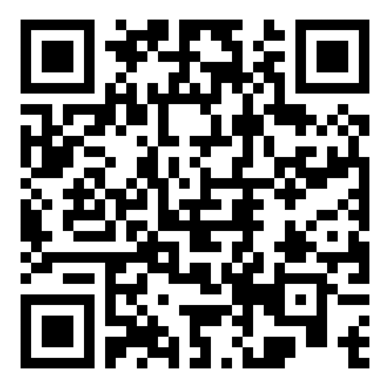

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def Brightness_level(image, threshold):
    Brightness_intensity = np.mean(image)
    if Brightness_intensity < 246 and Brightness_intensity > 245:
        return "normal"
    if Brightness_intensity < 124 and Brightness_intensity > 123:
        return "shaked"
    if Brightness_intensity < threshold:
        return "Dark"
    elif Brightness_intensity > 255 - threshold:
        return "Bright"
    else:
        return "normal"

def is_inverted(img):
        intensity = np.mean(image)

        if intensity > 30 and intensity < 35:
            return True
        else:
            return False


def inverted(img):
    inverted_image = cv2.bitwise_not(image)
    ret, thresh1 = cv2.threshold(img, 230, 250, cv2.THRESH_BINARY)
    return thresh1
def adjust_brightness(img,status):
    if status =="shaked":
        kernel = np.ones((5, 5), np.uint8)
        closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        _, image = cv2.threshold(closed_img, 60, 250, cv2.THRESH_BINARY)
        return image

    if status == "normal":
        return img
    elif is_inverted(img):
        adjusted = cv2.bitwise_not(img)
        return inverted(adjusted)
    elif status == "Dark" or status == "Bright":
        adjusted = cv2.equalizeHist(img)
        return adjusted

def check_salt_and_pepper(image,threshold):
    pixel_values = image.flatten()
    noise_ratio = np.sum((pixel_values == 0) | (pixel_values == 255)) / len(pixel_values)
    return noise_ratio > threshold


def salt_and_pepper_removal(img):
    denoise_median = cv2.bilateralFilter(img, 7,sigmaColor=50,sigmaSpace=40)
    return denoise_median



img_path = '/content/16-V3-QR-Code...-can-you-do-it.png'

image = cv2.imread(img_path,0)
Blurred_img = cv2.GaussianBlur(image,(3,3),0)
Brightness_status = Brightness_level(Blurred_img,threshold=60)
image2 =adjust_brightness(Blurred_img,Brightness_status)
if check_salt_and_pepper(image2,0.50):
    image2 = salt_and_pepper_removal(image2)
ret, thresh1 = cv2.threshold(image2, 130, 250, cv2.THRESH_BINARY)


plt.imshow(thresh1, cmap='gray')
plt.axis('off')
plt.show()

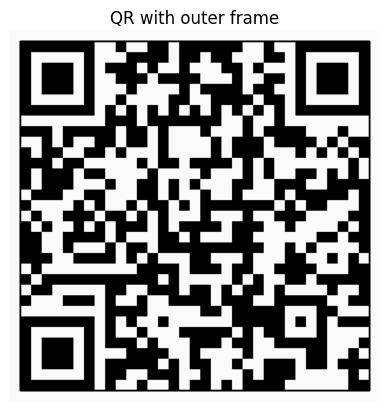

In [ ]:

Skewed = False
rotated = False
img_with_bbox = thresh1.copy()

def qrdetector(img):
    edges = cv2.Canny(img, 150, 300, apertureSize=3)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    detected = []
    if len(contours) and hierarchy is not None:
        hierarchy = hierarchy[0]
    for i in range(len(contours)):
        k = i
        c = 0
        while hierarchy[k][2] != -1:
            k = hierarchy[k][2]
            c += 1
        if c >= 5:
            detected.append(contours[i])
    return detected

detected_qr_contours = qrdetector(thresh1)


img_with_bbox = thresh1.copy()

if detected_qr_contours:
    if Skewed:
        all_contours = np.vstack([detected_qr_contours[i] for i in range(len(detected_qr_contours))])
        rect = cv2.minAreaRect(all_contours)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(img_with_bbox, [box], 0, (0, 255, 0), 2)
        width = rect[1][0]
        height = rect[1][1]
        src_pts = box.astype(np.float32)
        dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype=np.float32)
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        warped_img = cv2.warpPerspective(thresh1, M, (int(width), int(height)))

        plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
        plt.title('Warped QR')
        plt.axis('off')
        plt.show()
    else:
        min_x, min_y = np.inf, np.inf
        max_x, max_y = -np.inf, -np.inf
        for cnt in detected_qr_contours:
            x, y, w, h = cv2.boundingRect(cnt)
            min_x, max_x = min(min_x, x), max(max_x, x+w)
            min_y, max_y = min(min_y, y), max(max_y, y+h)
        cv2.rectangle(img_with_bbox, (min_x, min_y), (max_x, max_y), (0, 255, 0), 3)

plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
plt.title('QR with outer frame')
plt.axis('off')
plt.show()




In [ ]:
def intersect(l1, l2):
    delta = np.array([l1[1] - l1[0], l2[1] - l2[0]]).astype(np.float32)

    delta = 1 / delta
    delta[:, 0] *= -1

    b = np.matmul(delta, np.array([l1[0], l2[0]]).transpose())
    b = np.diagonal(b).astype(np.float32)

    res = cv2.solve(delta, b)
    return res[0], tuple(res[1].astype(np.int32).reshape((2)))
def rectify(image, corners, out_size):
    rect = np.zeros((4, 2), dtype = "float32")
    rect[0] = corners[0]
    rect[1] = corners[1]
    rect[2] = corners[2]
    rect[3] = corners[3]

    dst = np.array([
        [0, 0],
        [out_size[1] - 1, 0],
        [out_size[1] - 1, out_size[0] - 1],
        [0, out_size[0] - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    rectified = cv2.warpPerspective(image, M, out_size)
    return rectified

In [ ]:
def qr_code_outer_corners(image):
    outer_corners_found = False
    outer_corners = []



    contours, hierarchy = \
            cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnts = []
    centers = []

    hierarchy = hierarchy.reshape((-1, 4))
    for i in range(hierarchy.shape[0]):
        i_next, i_prev, i_child, i_par = hierarchy[i]
        if all(v == -1 for v in hierarchy[i][:3]):
            if all(v == -1 for v in hierarchy[i_par][:2]):
                ids = [i, i_par, hierarchy[i_par][3]]
                corner_cnts = []
                for id_ in ids:
                    cnt = contours[id_]
                    apprx = \
                        cv2.approxPolyDP(cnt, cv2.arcLength(cnt, True) * 0.02, True)
                    if len(apprx) == 4:
                        corner_cnts.append(apprx.reshape((4, -1)))
                if len(corner_cnts) == 3:
                    cnts.append(corner_cnts)
                    all_pts = np.array(corner_cnts).reshape(-1, 2)

                    centers.append(np.mean(all_pts, 0))

    if len(centers) == 3:
        distances_between_pts = np.linalg.norm(np.roll(centers, 1, 0) - centers, axis=1)
        max_dist_id = np.argmax(distances_between_pts)

        index_diag_pt_1 = max_dist_id
        index_diag_pt_2 = (max_dist_id - 1) % len(centers)
        index_corner_pt = (len(centers) - 1)*len(centers) // 2 - index_diag_pt_1 - index_diag_pt_2

        middle_pt = 0.5 * (centers[index_diag_pt_1] + centers[index_diag_pt_2])

        i_ul_pt = np.argmax(np.linalg.norm(cnts[index_corner_pt][-1] - middle_pt, axis=1))
        ul_pt = cnts[index_corner_pt][-1][i_ul_pt]

        for i in [index_diag_pt_1, index_diag_pt_2]:
            corner_cnts = cnts[i]
            outer_cnt = corner_cnts[-1]

            distances_to_mp = np.linalg.norm(outer_cnt - middle_pt, axis=1)
            max_dist_id = np.argmax(distances_to_mp)

            vec_from_mid_to_diag = outer_cnt[max_dist_id] - middle_pt
            vec_from_mid_to_corner = ul_pt - middle_pt
            cross_prod = np.cross(vec_from_mid_to_corner, vec_from_mid_to_diag)

            diff_idx = 0

            if cross_prod > 0:
                ur_pt = outer_cnt[max_dist_id]
                ur_pt_2 = outer_cnt[(max_dist_id + 1) % len(outer_cnt)]
            else:
                bl_pt = outer_cnt[max_dist_id]
                bl_pt_2 = outer_cnt[(max_dist_id - 1) % len(outer_cnt)]

        ret, br_pt = intersect((bl_pt, bl_pt_2), (ur_pt, ur_pt_2))

        if ret == True:
            outer_corners_found = True
            outer_corners = [ul_pt, ur_pt, br_pt, bl_pt]

    return outer_corners_found, outer_corners

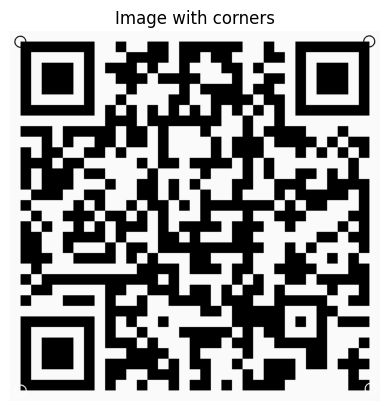

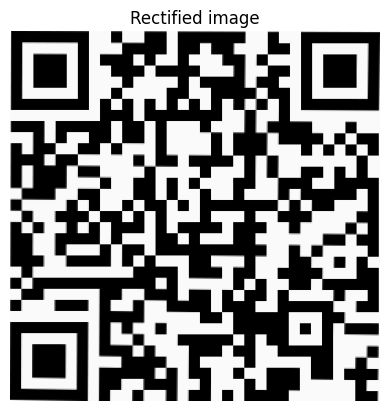

In [ ]:
result, corners = qr_code_outer_corners(thresh1)
qr_code_size = 300

if result:
    if all((0, 0) < tuple(c) < (thresh1.shape[1], thresh1.shape[0]) for c in corners):
        rectified = rectify(thresh1, corners, (qr_code_size, qr_code_size))
        img_with_corners = thresh1.copy()
        cv2.circle(img_with_corners, tuple(corners[0]), 15, (0, 255, 0), 2)
        cv2.circle(img_with_corners, tuple(corners[1]), 15, (0, 0, 255), 2)
        cv2.circle(img_with_corners, tuple(corners[2]), 15, (255, 0, 0), 2)
        cv2.circle(img_with_corners, tuple(corners[3]), 15, (255, 255, 0), 2)

        plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
        plt.title('Image with corners')
        plt.axis('off')
        plt.show()

        plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))
        plt.title('Rectified image')
        plt.axis('off')
        plt.show()
else:
  plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
  plt.title('Rectified image')
  plt.axis('off')
  plt.show()
  if Skewed:
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.title('wrapped image')
    plt.axis('off')
    plt.show()



In [ ]:
img = Image.fromarray(img_with_bbox)
img.save('result_image.png')

In [ ]:
from google.colab import files

files.download('result_image.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>